In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time
import csv
%matplotlib inline

### Import and Format Data

In [3]:
# import training.csv which contains a header row of face locations and 'image,' the column of lists of pixel values
with open("training.csv") as f:
    train_import = list(csv.reader(f))

# shuffle the data    
removed_header = train_import[1:]
shuffle = np.random.permutation(np.arange(len(removed_header)))
shuffled_train_import = [removed_header[i] for i in shuffle]
    
# divide the rows 80% for training and 20% for development    
train_portion = int(.8*(len(shuffled_train_import)))
dev_portion = len(shuffled_train_import) - train_portion

# extract training and development data
train_data = shuffled_train_import[:train_portion]
dev_data = shuffled_train_import[-dev_portion:]

In [4]:
'''GET TRAINING PIXEL VALUES AND TARGET DATA INTO USABLE NUMPY ARRAYS'''
# initialize the list of lists of pixel values 
train_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(train_data)):
    train_image_data.append([int(i) for i in list(train_data[row][30].split())])
# convert to a numpy array
train_image_data = np.array(train_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
train_image_data = train_image_data/255.0
    
# initialize array of the 30 different facial location target values (labels) for each example image
train_image_labels = np.empty((len(train_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(train_data)):
    for j in range(len(train_data[i][0:30])):
        if train_data[i][j] == '':
            train_image_labels[i][j] = float('nan')
        else: 
            train_image_labels[i][j] = float(train_data[i][j])

In [5]:
'''REPEATING SAME TREATMENT OF DATA THAT WAS DONE TO THE TRAINING PORTION'''
# initialize the development list of lists of pixel values 
dev_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(dev_data)):
    dev_image_data.append([int(i) for i in list(dev_data[row][30].split())])
# convert to a numpy array
dev_image_data = np.array(dev_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
dev_image_data = dev_image_data/255.0

# initialize array of the 30 different facial location target values (labels) for each example image
dev_image_labels = np.empty((len(dev_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(dev_data)):
    for j in range(len(dev_data[i][0:30])):
        if dev_data[i][j] == '':
            dev_image_labels[i][j] = float('nan')
        else: 
            dev_image_labels[i][j] = (float(dev_data[i][j]))

In [6]:
# characterizing data set
numFeatures = train_image_data[1].size
numClasses = 96
numTrainExamples = train_image_data.shape[0]
numDevExamples = dev_image_data.shape[0]
print('Features = %d' %(numFeatures))
print('Train set = %d' %(numTrainExamples))
print('Dev set = %d' %(numDevExamples))

Features = 9216
Train set = 5639
Dev set = 1410


#### Remove Rows with NaN Target Values

In [7]:
# remove rows where 'left_eye_center_x' == NaN values from the training and label data
non_NaN_list = np.invert((np.isnan(train_image_labels[:,0])))
cln_train_image_data = train_image_data[non_NaN_list]
cln_train_image_labels = train_image_labels[non_NaN_list]

# remove rows where 'left_eye_center_x' == NaN values from the dev and dev_label data
non_NaN_list = np.invert((np.isnan(dev_image_labels[:,0])))
cln_dev_image_data = dev_image_data[non_NaN_list]
cln_dev_image_labels = dev_image_labels[non_NaN_list]


### Logistic Regression - Facial Recognition

In [8]:
# (1) Parameters

tf.reset_default_graph()

# Constants
devY = tf.one_hot(np.rint(cln_dev_image_labels[:,0]), numClasses)
devX = tf.constant(cln_dev_image_data, dtype = tf.float32)

# placeholders
# In Tensorflow, placeholder are prepared to be filled with different python objects in the session.
# Using these placeholder, we don't need to transform the python objects train_data and train_labels into 
# Tensorflow object. tf.placeholder does this for us.
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')

# and Variables
w = tf.get_variable('w', shape=[numFeatures, numClasses])

In [9]:
# (2) Model

def model(input_layer):
    output_layer = tf.nn.softmax(tf.matmul(input_layer, w))
    return output_layer

In [10]:
# (3) Cost

def cost_func(data, labels):
    cc = tf.losses.mean_squared_error(labels, model(data))
    return  cc

80) RMSE = 3.3753


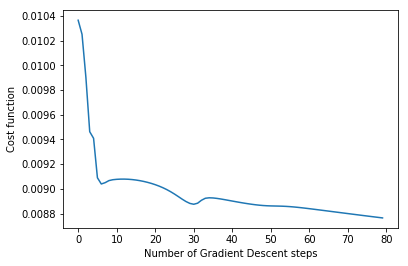

In [23]:
# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
cc = cost_func(x_, y_one_hot)
gd = tf.train.GradientDescentOptimizer(learning_rate=0.01)
step = gd.minimize(cc)
dev_preds = model(devX)

miniBatchSize = 10;
num_samples = train_image_data.shape[0]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_vec = []
    for i in range(80):
        for start, end in zip(range(0, num_samples, miniBatchSize), range(miniBatchSize, num_samples, miniBatchSize)):
            batch = cln_train_image_data[start:end], np.rint(cln_train_image_labels[:,0][start:end])
            # If we run step in the session, we specify x_ and y_ by using fed_dict as argument
            _, cost, dev__preds = sess.run([step, cc, dev_preds], feed_dict={x_: batch[0], y_: batch[1]})
        cost_vec.append(cost)
        clear_output(wait=True)
        # determine predicted x-coordiate for 'left_eye_center_x', named y_hat to match RMSE formula in competition
        y_hat = np.argmax(dev__preds, axis=1)
        # y represents the original coordinate for left_eye_center_x'
        y = cln_dev_image_labels[:,0]
        n = len(y)
        # root mean squared error
        rmse = np.sqrt(np.sum((y - y_hat)**2)/float(n))
        print('%d) RMSE = %.4f' %(i+1, rmse))
    
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()